In [72]:
import yfinance as yf
import pandas as pd
import numpy as np
    

def calculate_ma_and_ema(data):
    """
    Calculate Simple Moving Average (SMA), Exponential Moving Average (EMA),
    and other indicators like VWAP and RSI for the given dataset.
    """
    # Calculate Simple Moving Average (SMA)
    data["MA8"] = data["Close"].rolling(window=8).mean()
    data["MA21"] = data["Close"].rolling(window=21).mean()
    data["MA45"] = data["Close"].rolling(window=45).mean()
    data["MA100"] = data["Close"].rolling(window=100).mean()
    data["MA200"] = data["Close"].rolling(window=200).mean()

    # Calculate Exponential Moving Average (EMA)
    data["EMA8"] = data["Close"].ewm(span=8, adjust=False).mean()
    data["EMA21"] = data["Close"].ewm(span=21, adjust=False).mean()
    data["EMA45"] = data["Close"].ewm(span=45, adjust=False).mean()
    data["EMA100"] = data["Close"].ewm(span=100, adjust=False).mean()
    data["EMA200"] = data["Close"].ewm(span=200, adjust=False).mean()

    return data

def calculate_vwap(data):
    """
    Calculate the VWAP (Volume Weighted Average Price) for the given DataFrame.
    Expects columns: 'High', 'Low', 'Close', 'Volume'.
    """
    # Ensure columns exist and are numeric
    required_columns = ["High", "Low", "Close", "Volume"]
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Missing required column: {col}")
    
    # Convert necessary columns to numeric
    data[required_columns] = data[required_columns].apply(pd.to_numeric, errors="coerce")
    data.dropna(subset=required_columns, inplace=True)
    
    # Calculate VWAP
    data["Typical Price"] = (data["High"] + data["Low"] + data["Close"]) / 3
    data["VWAP"] = (
        (data["Typical Price"] * data["Volume"]).cumsum() / data["Volume"].cumsum()
    )
    
    # Drop intermediate calculations if not needed
    data.drop(columns=["Typical Price"], inplace=True, errors="ignore")
    
    return data


def calculate_rsi(data, rsi_period=14):
    """
    Calculate the Relative Strength Index (RSI) for the given dataset.
    """
    delta = data["Close"].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Use rolling mean for average gain and loss
    avg_gain = gain.rolling(window=rsi_period, min_periods=1).mean()
    avg_loss = loss.rolling(window=rsi_period, min_periods=1).mean()

    # Calculate Relative Strength (RS) and RSI
    rs = avg_gain / avg_loss
    data["RSI"] = 100 - (100 / (1 + rs))

    return data


def calculate_bollinger_bands(data, bb_period=20, bb_std_dev=2):
    """
    Calculate Bollinger Bands for the given dataset.
    """
    data["BB_Mid"] = data["Close"].rolling(window=bb_period).mean()
    data["BB_Upper"] = data["BB_Mid"] + bb_std_dev * data["Close"].rolling(window=bb_period).std()
    data["BB_Lower"] = data["BB_Mid"] - bb_std_dev * data["Close"].rolling(window=bb_period).std()
    return data


def calculate_pivot_points(data):
    """
    Calculate Pivot Points and support/resistance levels.
    """
    data["PP"] = (data["High"].shift(1) + data["Low"].shift(1) + data["Close"].shift(1)) / 3
    data["S1"] = 2 * data["PP"] - data["High"].shift(1)
    data["R1"] = 2 * data["PP"] - data["Low"].shift(1)
    data["S2"] = data["PP"] - (data["High"].shift(1) - data["Low"].shift(1))
    data["R2"] = data["PP"] + (data["High"].shift(1) - data["Low"].shift(1))
    return data


def calculate_fibonacci_retracement(data, lookback=14):
    """
    Calculate Fibonacci retracement levels for the given lookback period.
    """
    data["Fib_High"] = data["High"].rolling(window=lookback).max()
    data["Fib_Low"] = data["Low"].rolling(window=lookback).min()
    data["Fib_Levels"] = data.apply(
        lambda row: {
            "0.0%": row["Fib_Low"],
            "23.6%": row["Fib_Low"] + 0.236 * (row["Fib_High"] - row["Fib_Low"]),
            "38.2%": row["Fib_Low"] + 0.382 * (row["Fib_High"] - row["Fib_Low"]),
            "50.0%": (row["Fib_High"] + row["Fib_Low"]) / 2,
            "61.8%": row["Fib_Low"] + 0.618 * (row["Fib_High"] - row["Fib_Low"]),
            "100.0%": row["Fib_High"],
        },
        axis=1,
    )
    return data.drop(columns=["Fib_High", "Fib_Low"], errors="ignore")


def calculate_indicators(data, ma_period=14, rsi_period=14):
    """
    Calculate multiple indicators, including Moving Averages, VWAP, RSI,
    Bollinger Bands, Pivot Points, and Fibonacci Retracement Levels.
    """
    data = calculate_ma_and_ema(data)
    data = calculate_vwap(data)
    data = calculate_rsi(data, rsi_period)
    data = calculate_bollinger_bands(data)
    data = calculate_pivot_points(data)
    # data = calculate_fibonacci_retracement(data)
    return data


In [73]:
def fetch_and_store_data(ticker, interval, period, file_name="data.csv"):
    """
    Fetch stock data from yfinance and store it in a CSV file.
    Returns the processed DataFrame.
    """
    
    # Fetch data
    data = yf.download(ticker, interval=interval, period=period)

    if data.empty:
        print(f"No data fetched for {ticker}. Please check the ticker or interval/period.")
        return None
    
    # Reset index to include 'Date' as a column
    data.reset_index(inplace=True)
    
    # Ensure proper column names
    data.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

    # Calculate indicators
    data = calculate_indicators(data)
    
    # Save to CSV with proper formatting
    data.to_csv(file_name, index=False, header=True)
    print(f"{ticker} data saved to {file_name}.")
    return data

In [74]:
# Example usage before plotting
spy_data = fetch_and_store_data("SPY", "5m", "1mo")

[*********************100%***********************]  1 of 1 completed

SPY data saved to data.csv.


In [80]:
import plotly.graph_objects as go
import pandas as pd

def plot_interactive_with_gaps_skipped(data):
    """
    Plot interactive candlestick chart with indicators and skip gaps in data.
    """
    # Ensure index is datetime
    data = data.copy()
    if not pd.api.types.is_datetime64_any_dtype(data.index):
        data.index = pd.to_datetime(data.index)

    # Create candlestick chart with corrected colors
    fig = go.Figure(
        data=go.Candlestick(
            x=data.index,
            open=data["Open"],
            high=data["High"],
            low=data["Low"],
            close=data["Close"],
            name="Candlesticks",
        )
    )

     # Add indicators if they exist
    if "EMA8" in data.columns:
        fig.add_trace(go.Scatter(x=data.index, y=data["EMA8"], mode="lines", name="EMA8", line=dict(color="blue")))
    if "EMA21" in data.columns:
        fig.add_trace(go.Scatter(x=data.index, y=data["EMA21"], mode="lines", name="EMA21", line=dict(color="orange")))
    if "EMA45" in data.columns:
        fig.add_trace(go.Scatter(x=data.index, y=data["EMA45"], mode="lines", name="EMA45", line=dict(color="pink")))
    if "VWAP" in data.columns:
        fig.add_trace(go.Scatter(x=data.index, y=data["VWAP"], mode="lines", name="VWAP", line=dict(color="purple")))
    if "BB_Upper" in data.columns and "BB_Lower" in data.columns:
        fig.add_trace(go.Scatter(x=data.index, y=data["BB_Upper"], mode="lines", name="BB Upper", line=dict(color="green", dash="dash")))
        fig.add_trace(go.Scatter(x=data.index, y=data["BB_Lower"], mode="lines", name="BB Lower", line=dict(color="red", dash="dash")))
    # if "RSI" in data.columns:
    #     fig.add_trace(go.Scatter(x=data.index, y=data["RSI"], mode="lines", name="RSI", line=dict(color="yellow")))

    # Update layout
    fig.update_layout(
        title="Interactive Stock Price with Indicators (No Gaps)",
        xaxis_title="Date",
        yaxis_title="Price",
        template="plotly_dark",
        xaxis_rangeslider_visible=False,
        xaxis=dict(type="category"),
        hovermode="x unified",
        height=800,
    )

    # Show the plot
    fig.show()


In [81]:

# Load the data
data = pd.read_csv("data.csv", parse_dates=["Date"], index_col="Date")

if data is not None:
    plot_interactive_with_gaps_skipped(data)  # Plot only RTH data
else:
    print("Failed to fetch and process data for plotting.")


In [153]:
import pandas as pd
import matplotlib.pyplot as plt

def apply_strategy(data, initial_capital=10000, long_entry_threshold=0.002, take_profit=0.001, stop_loss=0.0005):
    """
    Apply a simple trading strategy:
    - Long entry when price increases by long_entry_threshold.
    - Exit with take profit or stop loss based on entry price.
    """
    data["Signal"] = 0  # 1 for long, -1 for short, 0 for no trade
    data["Exit"] = 0    # 1 for take profit, -1 for stop loss
    data["PnL"] = 0     # Profit or loss for the trade
    data["Balance"] = float(initial_capital)  # Track account balance

    running_balance = initial_capital
    entry_price = None
    position_active = False

    for i in range(1, len(data)):
        data.loc[data.index[i], "Balance"] = running_balance
        if not position_active:  # No active position
            # Check if the trend is bullish or bearish
            if (data["Close"].iloc[i] / data["Close"].iloc[i - 1] - 1) > long_entry_threshold:
                data.loc[data.index[i], "Signal"] = 1  # Long signal
                entry_price = data["Close"].iloc[i]
                position_active = True
                # print(f"Long entry at {data.index[i]}, Entry Price: {entry_price}")
            elif (data["Close"].iloc[i] / data["Close"].iloc[i - 1] - 1) < -long_entry_threshold:
                data.loc[data.index[i], "Signal"] = -1  # Short signal
                entry_price = data["Close"].iloc[i]
                position_active = True
                # print(f"Short entry at {data.index[i]}, Entry Price: {entry_price}")
        elif position_active:  # Position is active
            current_price = data["Close"].iloc[i]
            # Check for take profit
            if (current_price / entry_price - 1) >= take_profit:
                data.loc[data.index[i], "Exit"] = 1  # Take profit
                data.loc[data.index[i], "Signal"] = 0  # Close position
                profit = take_profit * data["Balance"].iloc[i - 1]  # PnL in dollars
                data.loc[data.index[i], "PnL"] = float(profit)
                running_balance = running_balance + profit
                data.loc[data.index[i], "Balance"] = running_balance
                position_active = False
                print(f"Take profit at {data.index[i]}, Entry Price: {round(entry_price,2)}, Exit Price: {round(current_price,2)}, PnL: {profit:.2f}, Balance: {running_balance:.2f}")
            # Check for stop loss
            elif (current_price / entry_price - 1) <= -stop_loss:
                data.loc[data.index[i], "Exit"] = -1  # Stop loss
                data.loc[data.index[i], "Signal"] = 0  # Close position
                loss = -stop_loss * data["Balance"].iloc[i - 1]  # PnL in dollars
                data.loc[data.index[i], "PnL"] = float(loss)
                running_balance = running_balance - loss
                data.loc[data.index[i], "Balance"] = running_balance
                position_active = False
                print(f"Stop loss at {data.index[i]}, Entry Price: {round(entry_price,2)}, Exit Price: {round(current_price,2)}, PnL: {loss:.2f}, Balance: {running_balance:.2f}")

    return data


In [158]:
def backtest(data):
    total_trades = int(len(data[data["Exit"] != 0]))
    total_pnl = float(data["PnL"].sum())
    final_balance = float(data["Balance"].iloc[-1])
    pnl_percentage = float(((final_balance / data["Balance"].iloc[0]) - 1) * 100)
    max_drawdown = float(((data["Balance"].cummax() - data["Balance"]) / data["Balance"].cummax()).max() * 100)

    metrics = {
        "Total Trades": total_trades,
        "Final Balance": final_balance,
        "Total PnL": total_pnl,
        "PnL (%)": pnl_percentage,
        "Max Drawdown (%)": max_drawdown,
    }
    return metrics


Take profit at 2024-12-06 14:50:00+00:00, Entry Price: 608.18, Exit Price: 608.86, PnL: 10.00, Balance: 10010.00
Take profit at 2024-12-11 14:55:00+00:00, Entry Price: 605.97, Exit Price: 606.61, PnL: 10.01, Balance: 10020.01
Stop loss at 2024-12-12 15:05:00+00:00, Entry Price: 606.0, Exit Price: 605.5, PnL: -5.01, Balance: 10025.02
Stop loss at 2024-12-13 15:00:00+00:00, Entry Price: 606.43, Exit Price: 605.79, PnL: -5.01, Balance: 10030.03
Take profit at 2024-12-16 15:00:00+00:00, Entry Price: 605.89, Exit Price: 606.65, PnL: 10.03, Balance: 10040.06
Take profit at 2024-12-17 14:50:00+00:00, Entry Price: 604.04, Exit Price: 604.83, PnL: 10.04, Balance: 10050.10


C:\Users\Vishnu\AppData\Local\Temp\ipykernel_18204\2140269984.py:40: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



Stop loss at 2024-12-18 19:05:00+00:00, Entry Price: 603.71, Exit Price: 601.17, PnL: -5.03, Balance: 10055.13
Take profit at 2024-12-18 19:30:00+00:00, Entry Price: 600.08, Exit Price: 600.73, PnL: 10.06, Balance: 10065.18
Take profit at 2024-12-18 20:05:00+00:00, Entry Price: 595.09, Exit Price: 595.81, PnL: 10.07, Balance: 10075.25
Stop loss at 2024-12-18 20:30:00+00:00, Entry Price: 593.14, Exit Price: 592.58, PnL: -5.04, Balance: 10080.29
Stop loss at 2024-12-18 20:40:00+00:00, Entry Price: 589.43, Exit Price: 586.85, PnL: -5.04, Balance: 10085.33
Stop loss at 2024-12-18 20:55:00+00:00, Entry Price: 589.88, Exit Price: 586.3, PnL: -5.04, Balance: 10090.37
Stop loss at 2024-12-19 14:35:00+00:00, Entry Price: 592.76, Exit Price: 591.85, PnL: -5.05, Balance: 10095.41
Stop loss at 2024-12-19 15:20:00+00:00, Entry Price: 590.72, Exit Price: 589.15, PnL: -5.05, Balance: 10100.46
Take profit at 2024-12-19 16:15:00+00:00, Entry Price: 588.12, Exit Price: 588.85, PnL: 10.10, Balance: 10110

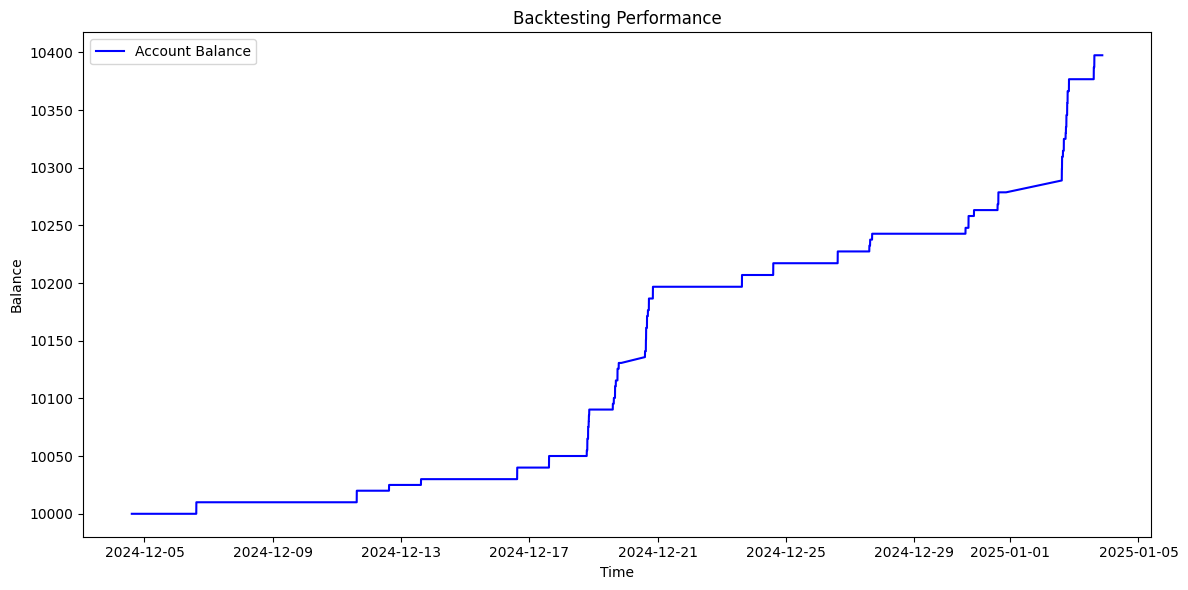

In [159]:
def plot_performance(data):
    plt.figure(figsize=(12, 6))
    
    # Plot balance
    plt.plot(data["Balance"], label="Account Balance", color="blue")
    plt.title("Backtesting Performance")
    plt.xlabel("Time")
    plt.ylabel("Balance")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Load data and apply strategy
data = pd.read_csv("data.csv", index_col="Date", parse_dates=True)
data = apply_strategy(data)

# Backtest
results = backtest(data)
print(results)

# Plot performance
plot_performance(data)